In [57]:
from tensorflow.keras import models ,layers ,optimizers
import seaborn as sns

In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [34]:
data_dir = path+'/Lung X-Ray Image'+'/Lung X-Ray Image'
data_dir

'/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image'

In [35]:
os.listdir(data_dir)

['Normal', 'Lung_Opacity', 'Viral Pneumonia']

In [48]:
def load_dataset_from_directory(data_dir, target_size=(224, 224), batch_size=32):

    datagen = ImageDataGenerator(rescale=1./255)
    dataset = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return dataset

dataset = load_dataset_from_directory(data_dir)

Found 3475 images belonging to 3 classes.


In [37]:
dataset.class_indices

{'Lung_Opacity': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [52]:
dataset.class_mode

'categorical'

In [49]:
dataset.image_shape

(224, 224, 3)

In [51]:
dataset.num_batches

109

In [41]:
#datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
target_size=(224, 224)
batch_size=32
EPOCHS = 20
train_datagen= ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen= ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen= train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical' ,
    )
val_gen= val_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical' ,
    )
NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())


Found 3475 images belonging to 3 classes.
Found 3475 images belonging to 3 classes.


In [42]:
def build_cnn():
    m = models.Sequential([
        layers.Input((*target_size, 3)),
        layers.Conv2D(32, 3, activation='relu'), layers.MaxPool2D(),
        layers.Conv2D(64, 3, activation='relu'), layers.MaxPool2D(),
        layers.Conv2D(128, 3, activation='relu'), layers.MaxPool2D(),
        layers.Flatten(), layers.Dense(256, activation='relu'), layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

In [43]:
def build_vgg():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size,3))
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    m = models.Model(inputs=base.input, outputs=out)
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m, base

In [46]:
cnn = build_cnn()
vgg, vgg_base = build_vgg()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.2, patience=3),
    tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
]

print("Training CNN from scratch")
history_cnn = cnn.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=callbacks)

print("Training VGG16 transfer learning")
history_vgg = vgg.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=callbacks)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training CNN from scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 608ms/step - accuracy: 0.5835 - loss: 41.7336 - val_accuracy: 0.7652 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 449ms/step - accuracy: 0.7384 - loss: 0.6182 - val_accuracy: 0.7528 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 452ms/step - accuracy: 0.7393 - loss: 0.5896 - val_accuracy: 0.8176 - val_loss: 0.4306 - learning_rate: 0.0010
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 453ms/step - accuracy: 0.7838 - loss: 0.5165 - val_accuracy: 0.8204 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - accuracy: 0.7960 - loss: 0.5062 - val_accuracy: 0.8403 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - accuracy: 0.7861 - loss: 0.5117 - val_accuracy: 0.8452 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 465ms/step - accuracy: 0.

In [58]:
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

vgg.compile(optimizer=optimizers.Adam(1e-5),
            loss='categorical_crossentropy', metrics=['accuracy'])
fine_hist = vgg.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 637ms/step - accuracy: 0.9137 - loss: 0.2242 - val_accuracy: 0.9306 - val_loss: 0.1778 - learning_rate: 1.0000e-05
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 600ms/step - accuracy: 0.9356 - loss: 0.1753 - val_accuracy: 0.9430 - val_loss: 0.1447 - learning_rate: 1.0000e-05
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 598ms/step - accuracy: 0.9387 - loss: 0.1571 - val_accuracy: 0.9419 - val_loss: 0.1385 - learning_rate: 1.0000e-05
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 599ms/step - accuracy: 0.9468 - loss: 0.1456 - val_accuracy: 0.9540 - val_loss: 0.1119 - learning_rate: 1.0000e-05
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 594ms/step - accuracy: 0.9442 - loss: 0.1349 - val_accuracy: 0.9623 - val_loss: 0.1029 - learning_rate: 1.0000e-05
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 595ms/step - accuracy: 0.9467 - loss: 0.1299 - val_accuracy: 0.9465 - val_loss: 0.1339 - learning_rate: 1.0000e-05
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 66s 60

109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
=== CNN Scratch Classification Report ===
                 precision    recall  f1-score   support

   Lung_Opacity       0.32      0.28      0.30      1125
         Normal       0.35      0.39      0.37      1250
Viral Pneumonia       0.32      0.32      0.32      1100

       accuracy                           0.33      3475
      macro avg       0.33      0.33      0.33      3475
   weighted avg       0.33      0.33      0.33      3475



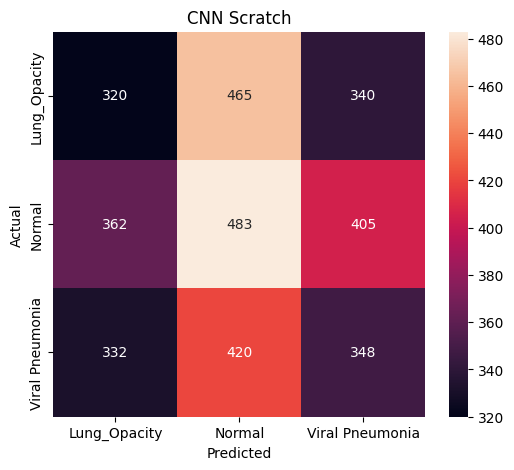

109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step
=== VGG16 Transfer (Fine-tuned) Classification Report ===
                 precision    recall  f1-score   support

   Lung_Opacity       0.33      0.33      0.33      1125
         Normal       0.39      0.39      0.39      1250
Viral Pneumonia       0.33      0.33      0.33      1100

       accuracy                           0.35      3475
      macro avg       0.35      0.35      0.35      3475
   weighted avg       0.35      0.35      0.35      3475



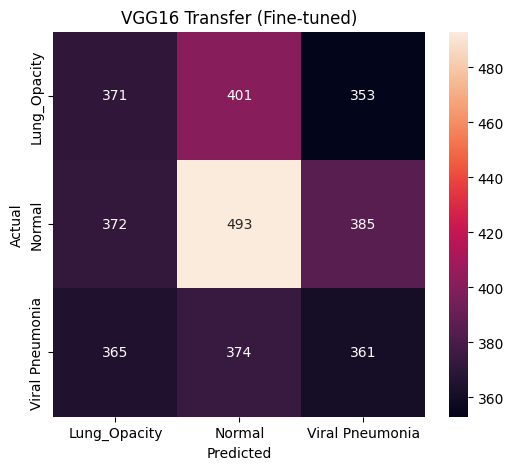

In [60]:
def eval_model(m, name):
    preds = m.predict(val_gen)
    y_true = val_gen.classes
    y_pred = np.argmax(preds, axis=1)
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(name); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

eval_model(cnn, "CNN Scratch")
eval_model(vgg, "VGG16 Transfer (Fine-tuned)")